Before getting to write code, let's look at the general architicture of a classification neural nerwork.

1. **Input Layer Shape**(in_feature): Same as number of features. 
2. **Hidden Layer(s)** Problem specific, min = 1, max = unlimited 
3. **Neurons per hidden** Problem specific generally 10 to 512
3. **output later shape**(out_feature): 1 per class 
4. **Hidden layer activation** Usually ReLU(rectified linear unit) but can be many others
5. **output activation** Sigmoid for binary classification and softmax for multiclass classification 

## Making Classification data and get it ready

In [2]:
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples, noise = 0.03, random_state=42)

In [3]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


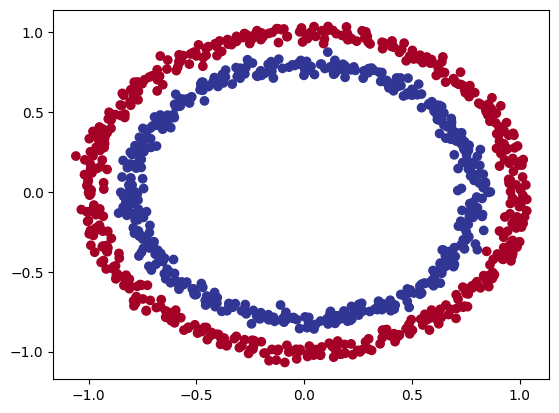

In [4]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [5]:
import torch 
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [7]:
import torch 
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we will set a model that has 2 layers
1. layer1 takes 2 inputs and outputs 5 This is known as having 5 hidden units or neurons
2. layer2 takes this 5 inputs and outputs one output 

In [8]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=5)
        self.layer2 = nn.Linear(in_features=5, out_features=1)
        
    def forward(self, x):
        return self.layer2(self.layer1(x))
    

model = CircleModelV0().to(device)
model

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

This could also be done using `nn.Sequential` like:

```python
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0
```

It's fantastic for straight-forward computation, however it always runs in sequential order.

So if you'd like something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom nn.Module subclass.

In [9]:
untrained_preds = model(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.3488],
        [0.4944],
        [0.0456],
        [0.4344],
        [0.1700],
        [0.2579],
        [0.5692],
        [0.5142],
        [0.0408],
        [0.5055]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


What is going in here?? the output is very different from the labels ¯\_(ツ)_/¯

Ok Let's set up the loss and optimizer, but different problems require different loss functions

| Loss function/Optimizer | Problem type | PyTorch Code |
| ----- | ----- | ----- |
| Stochastic Gradient Descent (SGD) optimizer | Classification, regression, many others. | [`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) |
| Adam Optimizer | Classification, regression, many others. | [`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) |
| Binary cross entropy loss | Binary classification | [`torch.nn.BCELossWithLogits`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) or [`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) |
| Cross entropy loss | Multi-class classification | [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) |
| Mean absolute error (MAE) or L1 Loss | Regression | [`torch.nn.L1Loss`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) | 
| Mean squared error (MSE) or L2 Loss | Regression | [`torch.nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) |  

Since we are working with binary classification, we'll use binary cross entropy loss function.

PyTorch has two binary cross entropy implementations:

`torch.nn.BCELoss()` - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
`torch.nn.BCEWithLogitsLoss()` - This is the same as above except it has a sigmoid layer (nn.Sigmoid) built-in (we'll see what this means soon).

The documentation says that `BCEWithLogistisLoss()`is more numerically stable than using `torch.nn.BCELoss()` after a Sigmoid layer.

In [10]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model.parameters(), lr = 0.1)

Now let's create an Evaluation metric which can be used to offer another prespective on how your model is going

if loss measures how wrong the model is then the evaluation measures how right it is

There're several evaluation metrics that can be used but let's start with accuracy.

In [11]:
def accuracy_fn(y_true, y_pred):
   correct = torch.eq(y_true,y_pred).sum().item()
   acc = (correct/len(y_pred))*100
   return acc

### Going from raw model outputs to predicted labels 

Right now our model outputs some raw data not even probabilites these are referred to as *logits* which are hard to interpret.

To turn these to prediction probabilty we will use *Sigmoid activation function*
and now the data says how much the model thinks the data point belongs to one class or another.

So to turn these values into tha prediction labels we can round the outputs of the sigmoid activation function.

In [12]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    
    model.train()
    
    # forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # calc loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70464, Accuracy: 59.62% | Test loss: 0.71409, Test acc: 55.00%
Epoch: 10 | Loss: 0.69840, Accuracy: 53.87% | Test loss: 0.70661, Test acc: 48.00%
Epoch: 20 | Loss: 0.69593, Accuracy: 52.88% | Test loss: 0.70304, Test acc: 46.50%
Epoch: 30 | Loss: 0.69480, Accuracy: 52.38% | Test loss: 0.70101, Test acc: 47.00%
Epoch: 40 | Loss: 0.69421, Accuracy: 51.38% | Test loss: 0.69967, Test acc: 46.50%
Epoch: 50 | Loss: 0.69384, Accuracy: 50.75% | Test loss: 0.69870, Test acc: 46.50%
Epoch: 60 | Loss: 0.69360, Accuracy: 51.12% | Test loss: 0.69795, Test acc: 47.00%
Epoch: 70 | Loss: 0.69343, Accuracy: 51.00% | Test loss: 0.69736, Test acc: 48.00%
Epoch: 80 | Loss: 0.69331, Accuracy: 51.25% | Test loss: 0.69688, Test acc: 48.00%
Epoch: 90 | Loss: 0.69323, Accuracy: 51.38% | Test loss: 0.69650, Test acc: 48.00%


In [18]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


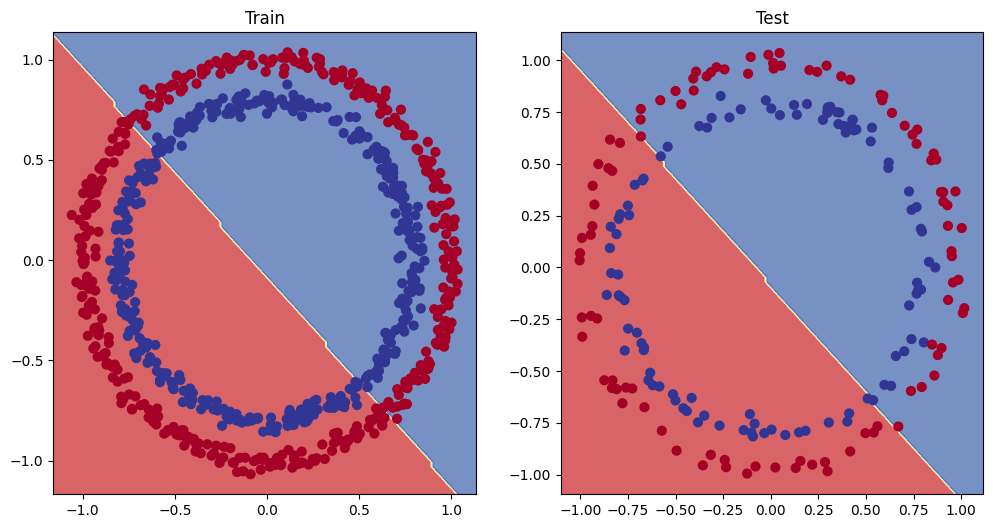

In [20]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

Damn! what a shitty model.

### Improving a model from a models prespective

we could do one of the following:
1. Adding more layers
2. Adding more hidden nuerons
3. Fitting for longer (more epochs)
4. Changing the activation function (^_−)☆
5. Change learning rate
6. Change the loss function
7. Use transfer learning

---

And to skip myself the headachs the answer is Non-Linearity (Changing the activation function)

PyTorch has a bunch of ready-made non-linear activation functions that do similar but different things.

One of the most common and best performing is ReLU) (rectified linear-unit, torch.nn.ReLU()).

In [13]:
from torch import nn

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <--- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.relu(x)
        x = self.layer_3(x)
        return x

model_1 = CircleModelV1().to(device)
print(model_1)

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [14]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr = 0.1)

In [15]:
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # loss and acc
    
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_train, y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_1.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_1(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")
    
    

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


Lets Gooooooo It's actually training ＼(＾▽＾)／

In [16]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

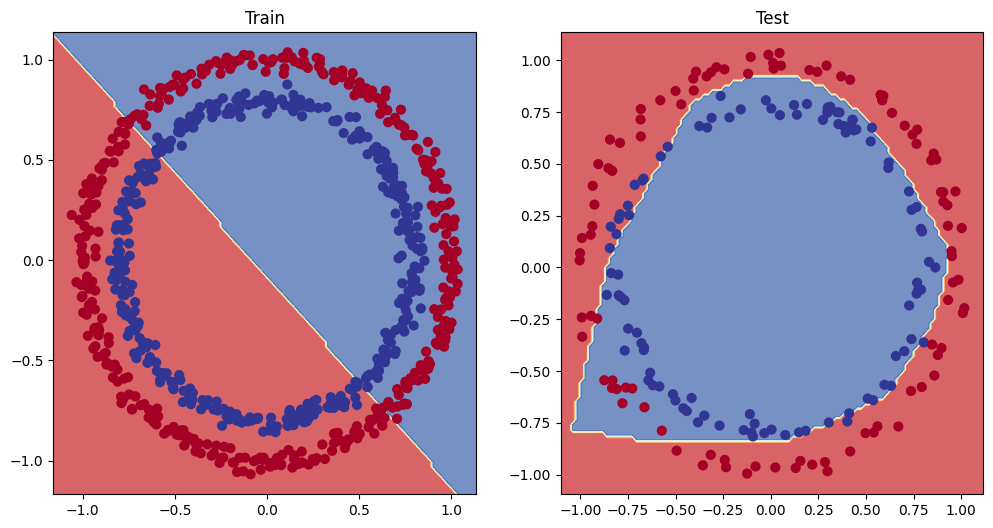

In [17]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train) # model = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test) # model_1 = has non-linearity

## Replicating Non Linear Activation Function

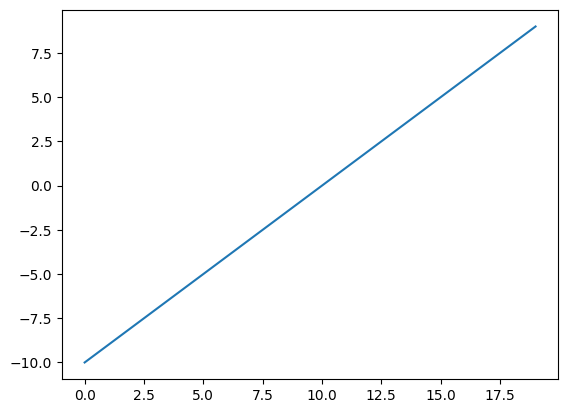

In [21]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
plt.plot(A);

In [ ]:
def relu(x):
    return torch.maximum(torch.tensor(0),x)
# Linear if > 0 and 0 ow
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

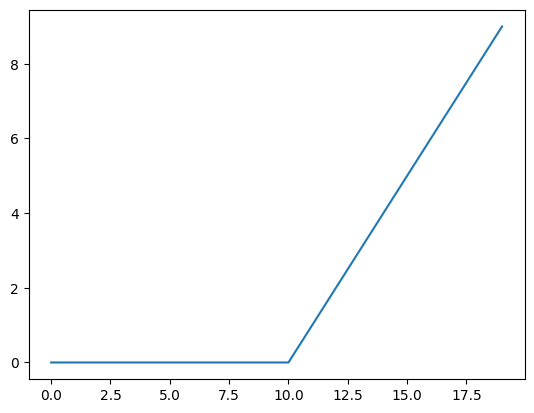

In [25]:
plt.plot(relu(A));

Sigmoid function is 

$$
S(x) = \frac{1}{1+e^{-x}}
$$

In [26]:
def sigmoid(x):
    return 1/ (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

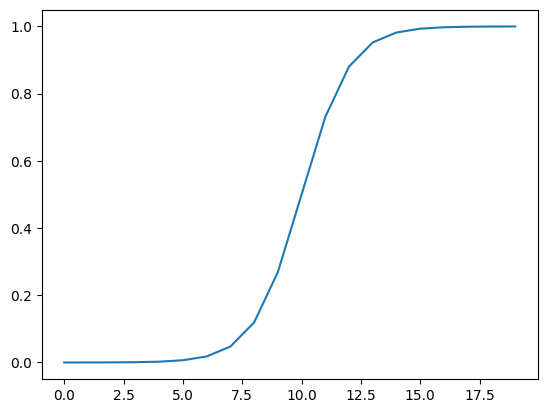

In [27]:
plt.plot(sigmoid(A));